# Forecasting Net Prophet
This project uses Pandas and Prophet from Meta Open Source along with time series data in the form of search traffic, stock prices, and daily revenue to identify trends and make predictions with the goal of maximizing profitability.

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/investor-relations). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

## Install and import the required libraries and dependencies

In [94]:
# Import the required libraries and dependencies
import pandas as pd
import holoviews as hv
from prophet import Prophet
import hvplot.pandas
import datetime as dt
from pathlib import Path
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

### Step 1.1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Use hvPlot to visualize the results. Do any unusual patterns exist?

In [47]:
# Upload the "google_hourly_search_trends.csv" file into Colab, then store in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
df_mercado_trends = pd.read_csv(
    Path('./Resources/google_hourly_search_trends.csv'),
    index_col='Date',
    parse_dates=True,
    infer_datetime_format=True
)

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [48]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


In [49]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Use hvPlot to visualize the data for May 2020
df_may_2020.hvplot(
    title='MercadoLibre Google Search Trends - May 2020'
)


:Curve   [Date]   (Search Trends)

### Step 1.2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [50]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020.sum()

# View the traffic_may_2020 value
traffic_may_2020


Search Trends    38181
dtype: int64

In [51]:
# Calcluate the monthly median search traffic across all months 
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.groupby(by=[df_mercado_trends.index.year, df_mercado_trends.index.month]).sum().median()

# View the median_monthly_traffic value
median_monthly_traffic


Search Trends    35172.5
dtype: float64

In [52]:
# Compare the search traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic


Search Trends    1.085536
dtype: float64

### Question: Did the Google search traffic increase during the month that MercadoLibre released its financial results?
It appears that yes, the search traffic increased by 8.6% in the month of May compared to the median monthly traffic for all months.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company.


### Step 2.1: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

In [90]:
# Group the hourly search data to plot (use hvPlot) the average traffic by the day of week 
df_mercado_trends.groupby(df_mercado_trends.index.dayofweek).mean().hvplot(
    title='MercadoLibre Search Trends by Day of Week',
    xlabel='Day of Week - Monday-Sunday'
)

:Curve   [Date]   (Search Trends)

### Step 2.2: Using hvPlot, visualize this traffic as a heatmap, referencing the `index.hour` as the x-axis and the `index.dayofweek` as the y-axis.

In [95]:
# Use hvPlot to visualize the hour of the day and day of week search traffic as a heatmap.
df_mercado_trends.hvplot.heatmap(
    x='index.hour',
    y='index.dayofweek',
    C='Search Trends',
    cmap='blues',
    title='MercadoLibre Search Trends by Hour of Day and Day of Week',
    ylabel='Day of Week - Monday-Sunday',
    xlabel='Hour of Day'
).aggregate(function=np.mean)

:HeatMap   [index.hour,index.dayofweek]   (Search Trends)

### Question: Does any day-of-week effect that you observe concentrate in just a few hours of that day?
Yes, across all of the days of the week, the search traffic appears to concentrate the most between 0:00 and 3:00, and 21:00 and 23:00.

### Step 2.3: Group the search data by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?

In [92]:
# Group the hourly search data to plot (use hvPlot) the average traffic by the week of the year
df_mercado_trends.groupby(df_mercado_trends.index.weekofyear).mean().hvplot(
    title='MercadoLibre Google Search Trends by Week of Year',
    xlabel='Week of Year'
)

C:\Users\lydia\anaconda3\envs\dev\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


:Curve   [Date]   (Search Trends)

### Question: Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?
Although the search traffic decreased between week 40 and 42, for the rest of the winter holiday period it does tend to increase, and then decreases sharply between week 51 and 52.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

### Step 3.1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [56]:
#create a dataframe from the mercado_stock_price.csv file
df_mercado_stock = pd.read_csv(
    Path('./Resources/mercado_stock_price.csv'),
    index_col='date',
    parse_dates=True,
    infer_datetime_format=True
)

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


In [57]:
# Use hvPlot to visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock.hvplot()


:Curve   [date]   (close)

In [58]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
mercado_stock_trends_df = pd.concat([df_mercado_trends, df_mercado_stock], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

,Search Trends,close
2016-06-01 09:00:00,6.0,135.16
2016-06-01 10:00:00,12.0,136.63
2016-06-01 11:00:00,22.0,136.56
2016-06-01 12:00:00,33.0,136.42
2016-06-01 13:00:00,40.0,136.10


,Search Trends,close
2020-07-31 11:00:00,20.0,1105.780
2020-07-31 12:00:00,32.0,1087.925
2020-07-31 13:00:00,41.0,1095.800
2020-07-31 14:00:00,47.0,1110.650
2020-07-31 15:00:00,53.0,1122.510


### Step 3.2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then use hvPlot to plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [59]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06) 
first_half_2020 = mercado_stock_trends_df.loc['2020-01':'2020-06']

# View the first and last five rows of first_half_2020 DataFrame
first_half_2020


,Search Trends,close
2020-01-02 09:00:00,9.0,601.085
2020-01-02 10:00:00,14.0,601.290
2020-01-02 11:00:00,25.0,615.410
2020-01-02 12:00:00,37.0,611.400
2020-01-02 13:00:00,50.0,611.830
...,...,...
2020-06-30 11:00:00,17.0,976.170
2020-06-30 12:00:00,27.0,977.500
2020-06-30 13:00:00,37.0,973.230
2020-06-30 14:00:00,45.0,976.500


In [60]:
# Use hvPlot to visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `hvplot(shared_axes=False, subplots=True).cols(1)`
first_half_2020.hvplot(
    shared_axes=False,
    subplots=True).cols(1)

:NdLayout   [Variable]
   :Curve   [index]   (value)

### Question: Do both time series indicate a common trend that’s consistent with this narrative?
Yes, although the stock prices and search traffic dropped after March of 2020, the stock prices more so, both did eventually recover. Starting in May 2020, the stock price began to climb past pre-pandemic levels.

### Step 3.3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [61]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)


In [62]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()


In [96]:
# Use hvPlot to visualize the stock volatility
mercado_stock_trends_df['Stock Volatility'].hvplot()

:Curve   [index]   (Stock Volatility)

**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [64]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()


In [87]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

,Search Trends,close,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,6.0,135.16,NaN,NaN,NaN
2016-06-01 10:00:00,12.0,136.63,6.0,NaN,0.010876
2016-06-01 11:00:00,22.0,136.56,12.0,NaN,-0.000512
2016-06-01 12:00:00,33.0,136.42,22.0,NaN,-0.001025
2016-06-01 13:00:00,40.0,136.10,33.0,0.006134,-0.002346


,Search Trends,close,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,20.0,1105.780,11.0,0.012837,0.006380
2020-07-31 12:00:00,32.0,1087.925,20.0,0.013549,-0.016147
2020-07-31 13:00:00,41.0,1095.800,32.0,0.013295,0.007239
2020-07-31 14:00:00,47.0,1110.650,41.0,0.013001,0.013552
2020-07-31 15:00:00,53.0,1122.510,47.0,0.013566,0.010678


### Step 3.4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [66]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()


,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


### Question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?
A 14% inverse relationship exists between the lagged search traffic and the stock volatility. A 1.8% positive correlation exists between the lagged search traffic and the stock price return.

## Step 4: Create a Time Series Model with Prophet
Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data.

### Step 4.1: Set up the Google search data for a Prophet forecasting model.

In [67]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
mercado_prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df.columns = ['ds', 'y']

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df = mercado_prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
mercado_prophet_df


,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38
...,...,...
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97


In [68]:
# Call the Prophet function, store as an object
model_mercado_trends = Prophet()


In [69]:
# Fit the time-series model.
model_mercado_trends.fit(mercado_prophet_df)


In [70]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model_mercado_trends.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame
future_mercado_trends.tail()


,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [71]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model_mercado_trends.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
forecast_mercado_trends.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.178720,80.878273,97.866908,44.178720,44.178720,45.370479,45.370479,45.370479,41.452658,...,1.860213,1.860213,1.860213,2.057608,2.057608,2.057608,0.0,0.0,0.0,89.549200
1,2016-06-01 01:00:00,44.179783,78.462054,94.188007,44.179783,44.179783,41.816276,41.816276,41.816276,37.943467,...,1.810132,1.810132,1.810132,2.062676,2.062676,2.062676,0.0,0.0,0.0,85.996059
2,2016-06-01 02:00:00,44.180845,66.744746,83.537222,44.180845,44.180845,31.492797,31.492797,31.492797,27.656524,...,1.768560,1.768560,1.768560,2.067713,2.067713,2.067713,0.0,0.0,0.0,75.673642
3,2016-06-01 03:00:00,44.181908,51.967224,68.854365,44.181908,44.181908,16.225604,16.225604,16.225604,12.417296,...,1.735591,1.735591,1.735591,2.072718,2.072718,2.072718,0.0,0.0,0.0,60.407512
4,2016-06-01 04:00:00,44.182970,34.890861,51.015128,44.182970,44.182970,-0.889236,-0.889236,-0.889236,-4.678106,...,1.711179,1.711179,1.711179,2.077691,2.077691,2.077691,0.0,0.0,0.0,43.293734


### Step 4.2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

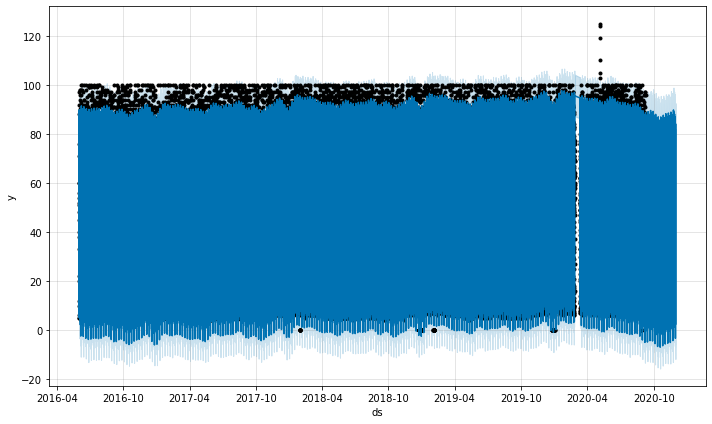

In [72]:
# Plot the Prophet predictions for the Mercado trends data
model_mercado_trends.plot(forecast_mercado_trends);

### Question: How's the near-term forecast for the popularity of MercadoLibre?
The near-term forecast shows the popularity decreasing slighlty, then increasing again. Overall, it seems fairly stable.

### Step 4.3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [73]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends = forecast_mercado_trends.set_index('ds')

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.549200,80.878273,97.866908
2016-06-01 01:00:00,85.996059,78.462054,94.188007
2016-06-01 02:00:00,75.673642,66.744746,83.537222
2016-06-01 03:00:00,60.407512,51.967224,68.854365
2016-06-01 04:00:00,43.293734,34.890861,51.015128
...,...,...,...
2020-11-30 04:00:00,39.421412,31.321402,47.890945
2020-11-30 05:00:00,23.950262,15.175472,32.649501
2020-11-30 06:00:00,11.984571,3.811884,20.273400


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

In [97]:
# From the forecast_mercado_trends DataFrame, use hvPlot to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours 
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-2000:,:].hvplot(
    height=400,
    width=1300,
    ylabel='Search Trends',
    xlabel='Date'
)


:NdOverlay   [Variable]
   :Curve   [index]   (value)

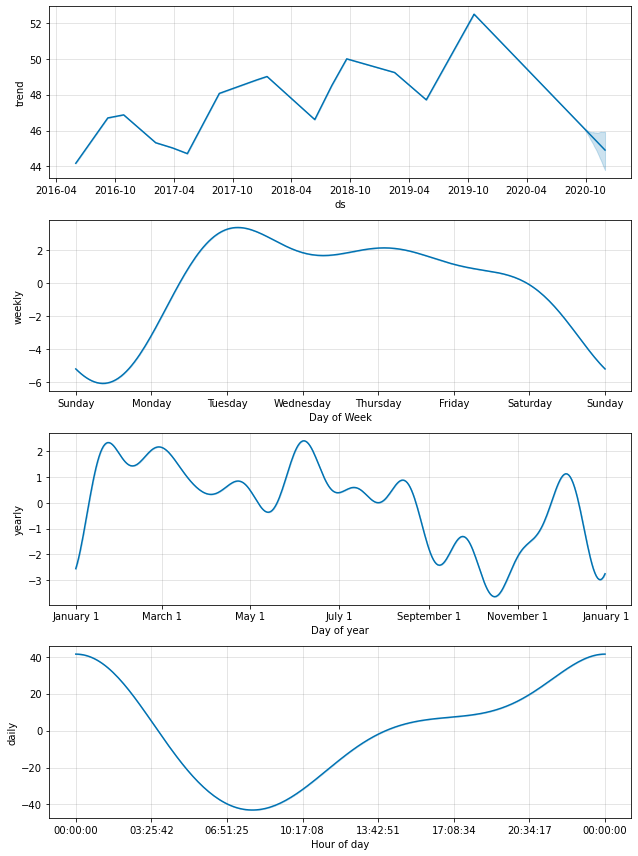

In [75]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends = forecast_mercado_trends.reset_index()

# Use the plot_components function to visualize the forecast results 
# for the forecast_mercado_trends dataframe
figures_mercado_trends = model_mercado_trends.plot_components(forecast_mercado_trends);


### Question: What time of day exhibits the greatest popularity?
Around midnight, or 0:00, seems to be the most popular time of day.

### Question: Which day of week gets the most search traffic? 
Tuesday gets the most search traffic.

### Question: What's the lowest point for search traffic in the calendar year?
The lowest point for search traffic in the calendar year appears to be around mid October.

## Step 5: Forecast Revenue by Using Time Series Models

A few weeks after your initial analysis, the finance group follows up to find out if you can help them solve a different problem. Your fame as a growth analyst in the company continues to grow!

Specifically, the finance group wants a forecast of the total sales for the next quarter. This will dramatically increase their ability to plan budgets and to help guide expectations for the company investors.

### Step 5.1: Read in the daily historical sales (that is, revenue) figures, and then apply a Prophet model to the data.

In [88]:
# Upload the "mercado_daily_revenue.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the DatetimeIndex
# Sales are quoted in millions of US dollars
df_mercado_sales = pd.read_csv(
    Path('./Resources/mercado_daily_revenue.csv'),
    index_col='date',
    parse_dates=True,
    infer_datetime_format=True
)

# Review the DataFrame
display(df_mercado_sales.head())
display(df_mercado_sales.tail())

,Daily Sales
date,
2019-01-01,0.626452
2019-01-02,1.301069
2019-01-03,1.751689
2019-01-04,3.256294
2019-01-05,3.732920


,Daily Sales
date,
2020-05-10,17.467814
2020-05-11,17.537152
2020-05-12,18.031773
2020-05-13,19.165315
2020-05-14,20.246570


In [77]:
# Use hvPlot to visualize the daily sales figures 
df_mercado_sales.hvplot()


:Curve   [date]   (Daily Sales)

In [78]:
# Apply a Facebook Prophet model to the data.

# Set up the dataframe in the neccessary format:
# Reset the index so that date becomes a column in the DataFrame
mercado_sales_prophet_df = df_mercado_sales.reset_index()

# Adjust the columns names to the Prophet syntax
mercado_sales_prophet_df.columns = ['ds', 'y']

# Visualize the DataFrame
mercado_sales_prophet_df


,ds,y
0,2019-01-01,0.626452
1,2019-01-02,1.301069
2,2019-01-03,1.751689
3,2019-01-04,3.256294
4,2019-01-05,3.732920
...,...,...
495,2020-05-10,17.467814
496,2020-05-11,17.537152
497,2020-05-12,18.031773
498,2020-05-13,19.165315


In [79]:
# Create the model
mercado_sales_prophet_model = Prophet()

# Fit the model
mercado_sales_prophet_model.fit(mercado_sales_prophet_df)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [80]:
# Predict sales for 90 days (1 quarter) out into the future.

# Start by making a future dataframe
mercado_sales_prophet_future = mercado_sales_prophet_model.make_future_dataframe(periods=90, freq='D')

# Display the last five rows of the future DataFrame
mercado_sales_prophet_future.tail()


,ds
585,2020-08-08
586,2020-08-09
587,2020-08-10
588,2020-08-11
589,2020-08-12


In [81]:
# Make predictions for the sales each day over the next quarter
mercado_sales_prophet_forecast = mercado_sales_prophet_model.predict(mercado_sales_prophet_future)

# Display the first 5 rows of the resulting DataFrame
mercado_sales_prophet_forecast.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,0.133057,-1.692349,2.051798,0.133057,0.133057,0.063738,0.063738,0.063738,0.063738,0.063738,0.063738,0.0,0.0,0.0,0.196796
1,2019-01-02,0.172238,-1.525614,2.216878,0.172238,0.172238,0.082783,0.082783,0.082783,0.082783,0.082783,0.082783,0.0,0.0,0.0,0.255022
2,2019-01-03,0.211420,-1.668797,2.244257,0.211420,0.211420,0.019584,0.019584,0.019584,0.019584,0.019584,0.019584,0.0,0.0,0.0,0.231003
3,2019-01-04,0.250601,-1.857752,2.085893,0.250601,0.250601,-0.058005,-0.058005,-0.058005,-0.058005,-0.058005,-0.058005,0.0,0.0,0.0,0.192596
4,2019-01-05,0.289782,-1.797223,2.090074,0.289782,0.289782,-0.123987,-0.123987,-0.123987,-0.123987,-0.123987,-0.123987,0.0,0.0,0.0,0.165795


### Step 5.2: Interpret the model output to identify any seasonal patterns in the company's revenue. For example, what are the peak revenue days? (Mondays? Fridays? Something else?)

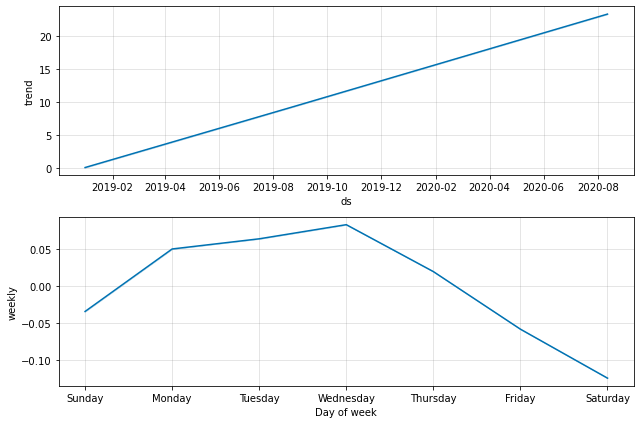

In [82]:
# Use the plot_components function to analyze seasonal patterns in the company's revenue
mercado_sales_prophet_model.plot_components(mercado_sales_prophet_forecast);


### Question: For example, what are the peak revenue days? (Mondays? Fridays? Something else?)
Monday, Tuesday, and Wednesday are the peak revenue days

### Step 5.3: Produce a sales forecast for the finance group. Give them a number for the expected total sales in the next quarter. Include the best- and worst-case scenarios to help them make better plans.

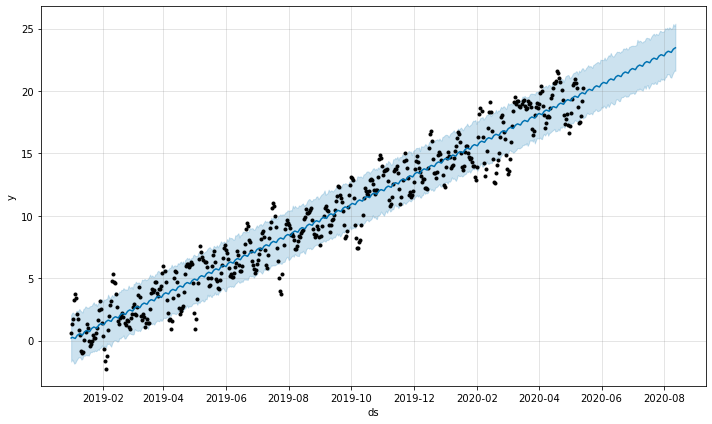

In [83]:
# Plot the predictions for the Mercado sales
mercado_sales_prophet_model.plot(mercado_sales_prophet_forecast);


In [84]:
# For the mercado_sales_prophet_forecast DataFrame, set the ds column as the DataFrame Index
mercado_sales_prophet_forecast = mercado_sales_prophet_forecast.set_index('ds')

# Display the first and last five rows of the DataFrame
mercado_sales_prophet_forecast


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2019-01-01,0.133057,-1.692349,2.051798,0.133057,0.133057,0.063738,0.063738,0.063738,0.063738,0.063738,0.063738,0.0,0.0,0.0,0.196796
2019-01-02,0.172238,-1.525614,2.216878,0.172238,0.172238,0.082783,0.082783,0.082783,0.082783,0.082783,0.082783,0.0,0.0,0.0,0.255022
2019-01-03,0.211420,-1.668797,2.244257,0.211420,0.211420,0.019584,0.019584,0.019584,0.019584,0.019584,0.019584,0.0,0.0,0.0,0.231003
2019-01-04,0.250601,-1.857752,2.085893,0.250601,0.250601,-0.058005,-0.058005,-0.058005,-0.058005,-0.058005,-0.058005,0.0,0.0,0.0,0.192596
2019-01-05,0.289782,-1.797223,2.090074,0.289782,0.289782,-0.123987,-0.123987,-0.123987,-0.123987,-0.123987,-0.123987,0.0,0.0,0.0,0.165795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-08,23.219270,21.068458,24.955016,23.216511,23.221752,-0.123987,-0.123987,-0.123987,-0.123987,-0.123987,-0.123987,0.0,0.0,0.0,23.095283
2020-08-09,23.258876,21.302467,25.052478,23.256084,23.261401,-0.034157,-0.034157,-0.034157,-0.034157,-0.034157,-0.034157,0.0,0.0,0.0,23.224719
2020-08-10,23.298483,21.482536,25.363490,23.295650,23.301078,0.050045,0.050045,0.050045,0.050045,0.050045,0.050045,0.0,0.0,0.0,23.348528


In [85]:
# Produce a sales forecast for the finance division
# giving them a number for expected total sales next quarter.
# Provide best case (yhat_upper), worst case (yhat_lower), and most likely (yhat) scenarios.

# Create a forecast_quarter Dataframe for the period 2020-07-01 to 2020-09-30
# The DataFrame should include the columns yhat_upper, yhat_lower, and yhat
mercado_sales_forecast_quarter = mercado_sales_prophet_forecast.loc['2020-07-01':'2020-09-30']

# Update the column names for the forecast_quarter DataFrame
# to match what the finance division is looking for 
mercado_sales_forecast_quarter = mercado_sales_forecast_quarter[['yhat', 'yhat_lower', 'yhat_upper']]

# Review the last five rows of the DataFrame
mercado_sales_forecast_quarter.tail()


,yhat,yhat_lower,yhat_upper
ds,,,
2020-08-08,23.095283,21.068458,24.955016
2020-08-09,23.224719,21.302467,25.052478
2020-08-10,23.348528,21.482536,25.363490
2020-08-11,23.401827,21.640007,25.191606
2020-08-12,23.460478,21.611270,25.396366


In [86]:
# Display the summed values for all the rows in the forecast_quarter DataFrame
mercado_sales_forecast_quarter.sum()


yhat           969.559258
yhat_lower     886.883498
yhat_upper    1051.517026
dtype: float64

### Question: Based on the forecast information generated above, produce a sales forecast for the finance division, giving them a number for expected total sales next quarter. Include best and worst case scenarios, to better help the finance team plan.
Based on the forecast information, the finance division can expect a most likely outcome of 969.56 million dollars of total sales for the next quarter, with a worst case scenario of 887.45 million dollars of total sales, and a best case scenario of 1.052 billion dollars of total sales.